# Starter example for pyicon

Some specific commands for Jupyter:

In [1]:
# Jupyter Notebook with widget matplotlib plots
#%matplotlib notebook
# Jupyter Lab with widget matplotlib plots
#%matplotlib widget 
# with Jupyter and Jupyter Lab but without widget matplotlib plots
%matplotlib inline
%load_ext autoreload
%autoreload 2

Load necessary modules:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import sys
import pyicon as pyic

## Names and paths

Define the name of the simulation, its grid, the path to the data and paths to the grid:

In [3]:
run = 'nib0004'
runname = 'icon_08'
gname = 'r2b6'
lev = 'L64'

path_data     = f'/mnt/lustre01/work/mh0033/m300602/proj_vmix/icon/{runname}/icon-oes/experiments/{run}/'
string = 'asdf{}'.format(run)
string2 = 'asdf'+run+'asdf'
string3 = 'asdf%sasdf' % (run)
path_grid     = f'/mnt/lustre01/work/mh0033/m300602/icon/grids/{gname}/'
path_ckdtree  = f'{path_grid}ckdtree/'
fpath_fx      = f'{path_grid}{gname}_{lev}_fx.nc'

## Pyicon IconData object

Create a pyicon IconData object. This object contains information about the grid, and the time steps which are in the given data directory.

In [30]:
lon_reg = [-90,-30]
lat_reg = [0,30]
IcD = pyic.IconData(
               fname        = run+'_????????????????.nc',
               path_data    = path_data,
               path_grid    = path_grid,
               gname        = gname,
               lev          = lev,
               #path_ckdtree = path_ckdtree,
               #section_name = '',
               #fpath_fx     = fpath_fx,
               do_triangulation = True,
               omit_last_file   = False,
               lon_reg = lon_reg,
               lat_reg = lat_reg,
               calc_coeff = False,
              )

In [31]:
# IcD.Lon[0,:]

In [32]:
# Lon, Lat, lon, lat, ind_reg, indx, indy = pyic.crop_regular_grid(lon_reg, lat_reg, IcD.Lon, IcD.Lat)

In [33]:
# ind_reg[:220]

In [34]:
IcD.crop_data

True

## Load the data

Specify some indices (it for time and iz for depth) that should be used to load a subset of the data (one level at one time step):

In [35]:
# --- specify time step
it = np.argmin(np.abs(IcD.times-np.datetime64('2295-01-01T00:00:00')))
# --- specify depth level
iz = np.argmin(np.abs(IcD.depthc-100.))

Finally load the data (in this case temperature):

In [36]:
f = Dataset(IcD.flist_ts[it], 'r')
to_all = f.variables['to'][IcD.its[it],iz,:]
f.close()

In [37]:
to = to_all[IcD.ind_reg_tri]

Mask land values (assuming 0 data values to be land):

In [38]:
to[to==0.0] = np.ma.masked

We can calculate the mean value:

In [39]:
to.mean()

20.607012905103822

or get information about the size of the data:

In [40]:
to.shape

(11392,)

## Plotting on the original triangular grid

First mask land values (simply assuming that 0 data values are land):

In [41]:
mask_land = to.mask
# The mask needs to be applied to IconData triangulation object. 
# It is important to add the mask to the IcD.mask_bt mask which masks longitudinally periodic triangles.
IcD.Tri.set_mask(IcD.mask_bt+mask_land)

In [61]:
IcD.Tri.x.shape, IcD.Tri.edges.shape, IcD.Tri.neighbors.shape, IcD.clon.shape

((120947,), (15810, 2), (11392, 3), (11392,))

In [68]:
IcD.indx

array([300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312,
       313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325,
       326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338,
       339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351,
       352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364,
       365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377,
       378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390,
       391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403,
       404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416,
       417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429,
       430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442,
       443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455,
       456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468,
       469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 48

(0.0, 30.0)

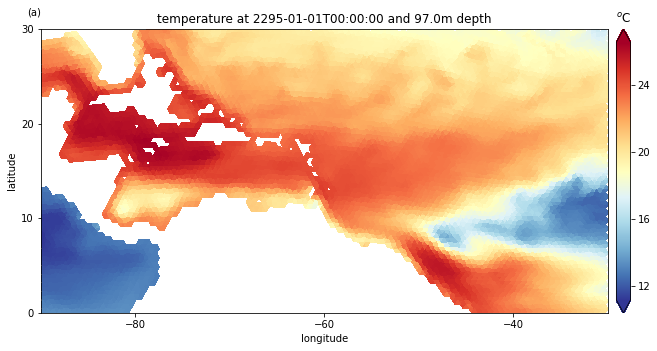

In [54]:
hca, hcb = pyic.arrange_axes(1,1, plot_cb=True, asp=0.5, fig_size_fac=2.5)
ii=-1

ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(IcD.Tri, to, ax=ax, cax=cax, clim='auto')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_title('temperature at %s and %.1fm depth'%(IcD.times[it], IcD.depthc[iz]))
cax.set_title('$^o$C')
ax.set_xlim(lon_reg)
ax.set_ylim(lat_reg)

## Interpolate data to a regular grid

Use the pyicon interp_to_rectgrid function. The path to the regular grid ckdtree file (fpath_ckdtree) needs to be specified. It decides which regular grid is taken but only those grids can be chosen which were calculated and saved externally.

In [55]:
fpath_ckdtree = f'{path_grid}ckdtree/rectgrids/{gname}_res0.30_180W-180E_90S-90N.npz'
lon, lat, toi = pyic.interp_to_rectgrid(to_all, fpath_ckdtree, mask_reg=IcD.ind_reg_rec, indx=IcD.indx, indy=IcD.indy, coordinates='clat clon')

Text(0.5, 1.0, '$^o$C')

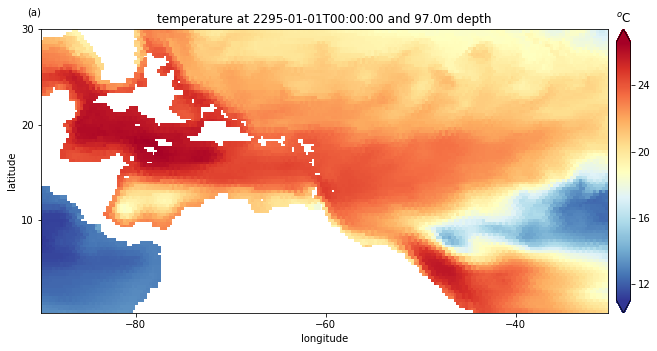

In [56]:
hca, hcb = pyic.arrange_axes(1,1, plot_cb=True, asp=0.5, fig_size_fac=2.5)
ii=-1

ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(IcD.lon, IcD.lat, toi, ax=ax, cax=cax, clim='auto')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_title('temperature at %s and %.1fm depth'%(IcD.times[it], IcD.depthc[iz]))
cax.set_title('$^o$C')